Data Cleaning Web Scraping Results

In [ ]:
import os
import sys
import fileinput
import re
import csv

In [ ]:
# add coma for list 
with open('/Users/David_Tsai/Desktop/fb_url.txt', 'r') as istr:
    with open('/Users/David_Tsai/Desktop/fb_output.txt', 'w') as ostr:
        for line in istr:
            line = line.rstrip('\n') + ','
            print(line, file= ostr)


In [ ]:
# remove percentage using regular expression
with open('/Users/David_Tsai/Desktop/fb_output.txt', 'r') as infile:
    with open('/Users/David_Tsai/Desktop/fb_final.txt', 'w') as outfile:
        for line in infile:
            new_str = ':'.join(line.split(':')[1:])
            outfile.write(new_str)


In [ ]:
# read csv to list
with open('/Users/David_Tsai/Desktop/FB_url_cleaned/fb_final.txt') as f:
    lines = [line.strip() for line in f]

lines = [i.strip(',') for i in lines]
len(lines)

In [1]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import bs4
from googlesearch import search
from contextlib import closing
import requests
from requests import get
from requests.exceptions import RequestException

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import time
import langid

from sklearn import preprocessing

import scipy
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pylab as plt

In [ ]:
pages = pd.read_csv('/Users/David_Tsai/Desktop/FB_url_cleaned/pages_count.csv')

In [ ]:
pages_count = pages.iloc[2639:2690]

In [ ]:
pages_count['query'] = pages_count['name'].astype(str) + ' - facebook'

In [ ]:
query_list = []
for q in pages_count['query']:
  query_list.append(q)

#print(query_list)
len(query_list)

In [ ]:
results_list = []

for q in query_list:
  for i in search(q,     
         tld = 'com',   # the top level domain
         lang = 'zh-tw',   
         num = 1,       # number of results per page
         start = 0,     # first result 
         stop = 1,      # last result 
         pause = 2,     # lapse between HTTP requests
         user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36"
         ):
    time.sleep((30-5)*np.random.random()+5) #randomize sleep time
    results_list.append(i)
    print("{0:.00%}".format(len(results_list)/len(query_list)) + ':' + i)


In [ ]:
res = lines + results_list
len(res)

In [ ]:
pages_all = pages[(pages['count'] < 10) & (pages['count'] >= 5)]

In [ ]:
res_df = pd.DataFrame(res)
res_df.head(5)

In [ ]:
pages_all = pages_all.reset_index()
pages_all.head(5)

In [ ]:
pages_df = pd.concat((pages_all, res_df), axis = 1, join = 'outer')
pages_df.tail(5)

In [ ]:
pages_df.url = np.where((pages_df['url'].str[-1] == ('/')), pages_df['url'], pages_df['url'] + '/')
#if np.where(pages_df['url'].str[-1] is not ('/')):
#    pages_df['url'] = pages_df['url'] + '/'

In [ ]:
pages_df['url_about'] = pages_df['url'].astype(str) + 'about/?ref=page_internal'

In [ ]:
pages_df.to_csv('/Users/David_Tsai/Desktop/Pages_0830.csv')

Get Category (Done on Google Colab)

In [ ]:
page_list = []

for p in pages_df['url_about']:
  page_list.append(p)

len(page_list)

In [ ]:
# ---------- selenium ----------

# apt update
# apt install chromium-chromedriver
# pip install selenium

from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

wd = webdriver.Chrome(executable_path = '/Users/David_Tsai/Desktop/FB_url_cleaned/chromedriver', options= options)

In [ ]:
# selenium with beautifulsoup

category_list = []
divs_none = "N/A"

for i in page_list:
  wd.get(i)
  time.sleep((20-5)*np.random.random()+5) #randomize sleep time
  
  raw_html = wd.page_source
  soup = BeautifulSoup(raw_html, 'html.parser')
  divs = soup.find_all("div", {"class": "_4bl9 _5m_o"})

  if len(divs) == 0: # to check if the link is broken or not
    category_list.append(divs_none)
  
  else:
    for d in divs:
      divs = d.get_text()
      category_list.append(divs)
     
  print("{0:.00%}".format(len(category_list)/len(page_list)))


In [ ]:
pages_count['category'] = pd.Series(category_list)
pages_count.sample(10)

Translate non-EN category to EN

In [ ]:
pages = pd.read_csv('/Users/David_Tsai/Desktop/FB_url_cleaned/PagesCategory0830.csv')

In [ ]:
pages['category'] = pages['category'].astype('str')

In [ ]:
def lang_classify(x):
    langid.set_languages(['zh', 'en'])
    lang, score = langid.classify(x)
    return lang

pages['cat_lang'] = pages['category'].apply(lang_classify)

In [ ]:
pages.groupby(['cat_lang']).size()

In [ ]:
pages_zh = pages[pages['cat_lang'] == 'zh']

In [ ]:
from googletrans import Translator

translator = Translator(service_urls = ['translate.google.com'])


def trans(x):
    translations = translator.translate(x)
    return translations.text

pages_zh['category'] = pages_zh['category'].apply(trans)


In [ ]:
pages_zh = pages_zh[['index', 'name', 'count', 'category']]
pages_zh = pages_zh.sort_values(['count'], ascending = False)

In [ ]:
pages_zh = pages_zh.reset_index()

In [ ]:
pages_zh = pages_zh[['name', 'count', 'category']]

pages2 = pages_zh.set_index('name').combine_first(pages.set_index('name')).reset_index()

In [ ]:
pages2.to_csv('/Users/David_Tsai/Desktop/FB_url_cleaned/PagesCategory0831.csv')

Merge DataFrames

In [ ]:
pages = pd.read_csv('/Users/David_Tsai/Desktop/FB_url_cleaned/PagesCategory0816.csv')
pages2 = pd.read_csv('/Users/David_Tsai/Desktop/FB_url_cleaned/PagesCategory0831.csv')

In [ ]:
pages.shape

In [ ]:
pages['category'] = pages['category'].astype('str')
pages['cat_lang'] = pages['category'].apply(lang_classify)

In [ ]:
pages_zh = pages[pages['cat_lang'] == 'zh']

In [ ]:
pages_zh['category'] = pages_zh['category'].apply(trans)

In [ ]:
pages_zh = pages_zh[['name', 'count', 'category']]
pages_zh = pages_zh.sort_values(['count'], ascending = False)

In [ ]:
pages_zh = pages_zh.reset_index()

In [ ]:
pages_zh = pages_zh[['name', 'count', 'category']]

pages3 = pages_zh.set_index('name').combine_first(pages.set_index('name')).reset_index()

In [ ]:
Pages = pd.concat([pages3, pages2], ignore_index= True)

In [ ]:
Pages = Pages[['name', 'count', 'category']]
Pages = Pages.sort_values(['count'], ascending = False)
Pages = Pages.reset_index()
Pages = Pages[['name', 'count', 'category']]

In [ ]:
Pages = Pages[['name', 'count', 'category']]

In [ ]:
Pages.head(10)

In [ ]:
Pages.to_csv('/Users/David_Tsai/Desktop/FB_url_cleaned/PagesFinal0831.csv')

Clustering

In [2]:
Pages = pd.read_csv('/Users/David_Tsai/Desktop/FB_url_cleaned/PagesFinal0831.csv')

In [3]:
Pages.shape

(2690, 4)

In [4]:
Pages.head(5)

,Unnamed: 0,name,count,category
0,0,Duncan,65.0,Artist · Leisure Education
1,1,蔡英文 Tsai Ing-wen,60.0,Politician
2,2,五月天,59.0,Musician/Band
3,3,五月天 阿信,54.0,Musician/Band
4,4,阿滴英文,47.0,Blogger


In [5]:
if Pages['category'].str.contains(' · ').any():
    Pages['cat_cleaned'] = Pages['category'].str.split(' · ')

In [6]:
Pages.head(5)

,Unnamed: 0,name,count,category,cat_cleaned
0,0,Duncan,65.0,Artist · Leisure Education,"[Artist, Leisure Education]"
1,1,蔡英文 Tsai Ing-wen,60.0,Politician,[Politician]
2,2,五月天,59.0,Musician/Band,[Musician/Band]
3,3,五月天 阿信,54.0,Musician/Band,[Musician/Band]
4,4,阿滴英文,47.0,Blogger,[Blogger]


In [7]:
Pages_matrix = pd.get_dummies(Pages['cat_cleaned'].apply(pd.Series).stack().sum(level = 0))

In [8]:
Pages_array = Pages_matrix.to_numpy()

In [9]:
Pages_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

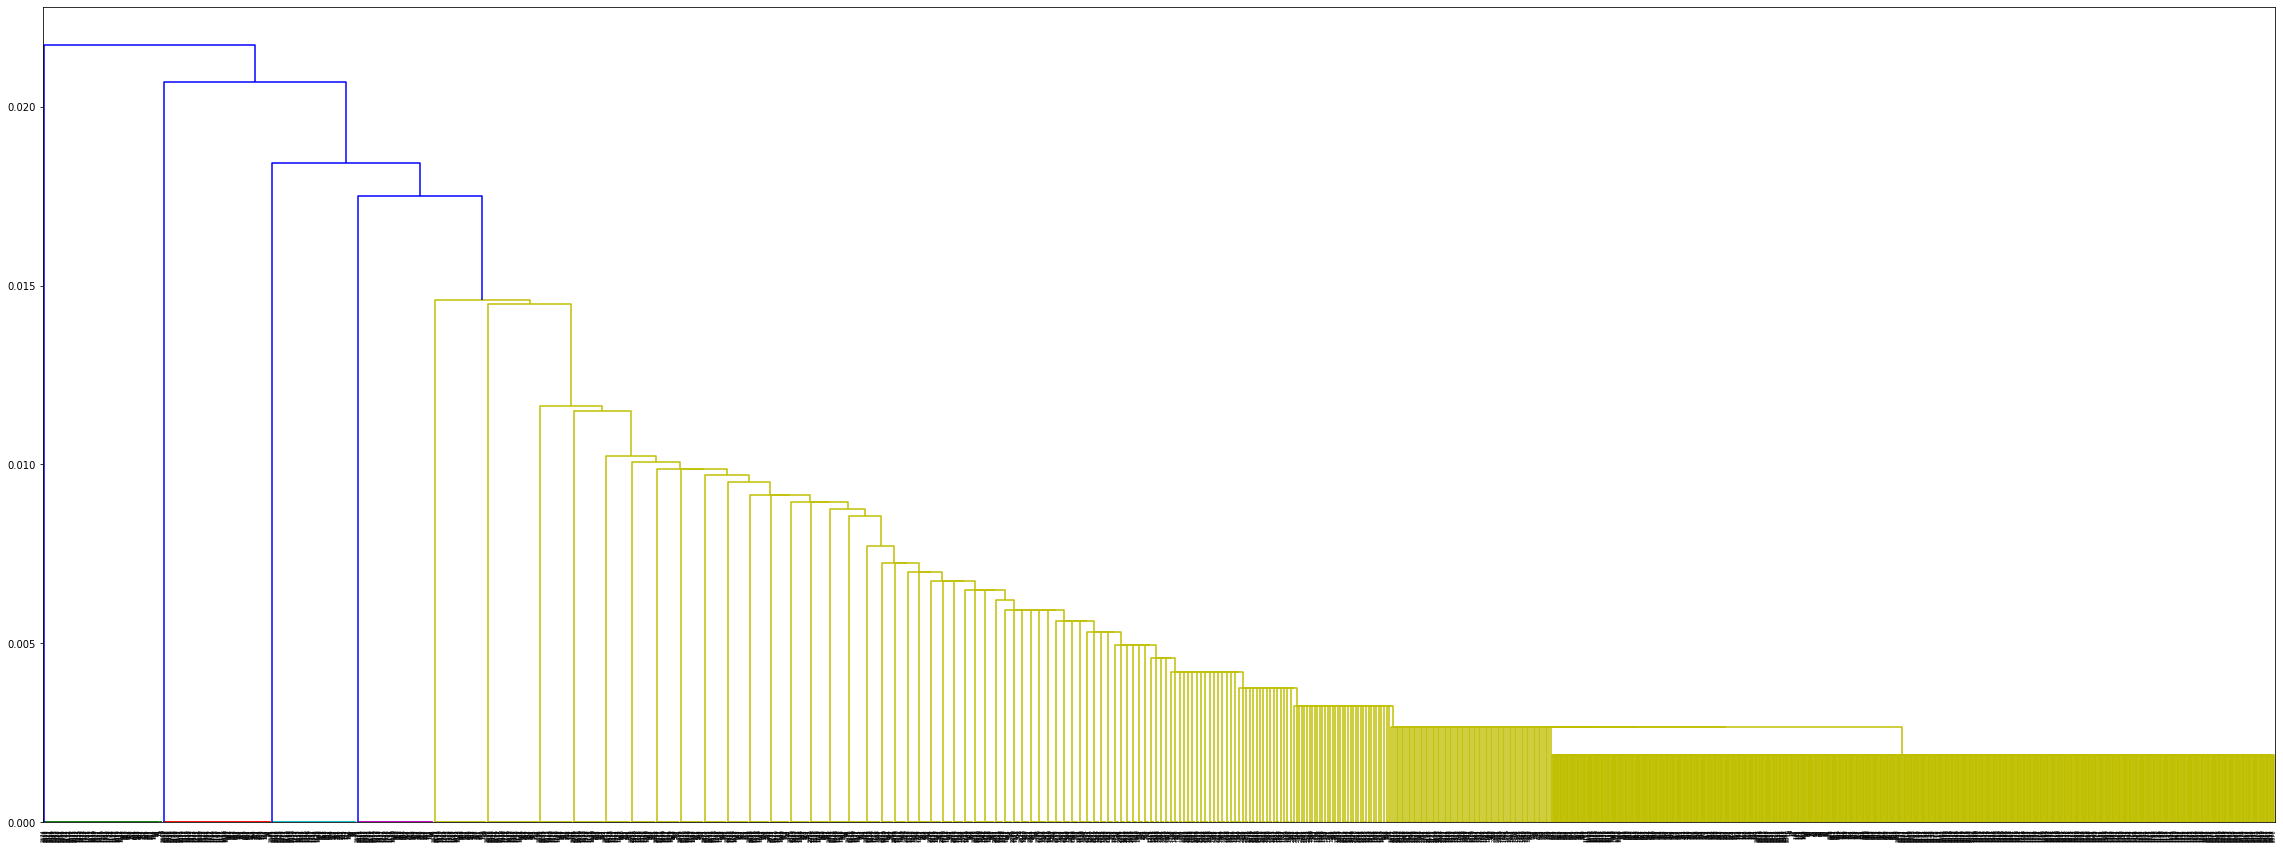

In [10]:
plt.figure(figsize=(40,15))

# hamming distance with complete linking
hier_clust = sch.linkage(sch.distance.pdist(Pages_array, metric= 'hamming'), 'ward')

#compute the dendrogram
dend = sch.dendrogram(hier_clust)

plt.show()


In [ ]:
model = AgglomerativeClustering(n_clusters = )

model = model.fit(Pages_array)

In [ ]:
cluster_label = model.labels_

In [ ]:
Pages['cluster'] = pd.Series(cluster_label)
Pages.sample(10)

In [ ]:
Pages.groupby(['cluster']).size()